In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm


In [ ]:
# Simulation parameters
Nx = 32             # Number of grid points in x direction (small for testing)
Ny = 64             # Number of grid points in y direction (small for testing)
Lx = 1.0            # Domain length in x
Ly = 2.0            # Domain length in y
dx = Lx / Nx        # Grid spacing in x
dy = Ly / Ny        # Grid spacing in y
gamma = 1.4         # Ratio of specific heats
ga = -10.0          # Gravitational acceleration
C = 0.2             # CFL number
save_interval = 20  # Save/visualize every N steps


In [ ]:
# Derived parameters (for artificial diffusion)
def update_diffusion_coeffs(dt):
    k1 = 0.0125 * (dx**2) / (2 * dt)
    k2 = 0.125 * (dx**2) / (2 * dt)
    k3 = 0.0125 * (dx**2) / (2 * dt)
    return k1, k2, k3

# Initialize the grid
def initialize_grid():
    r = np.zeros((Nx, Ny))
    ru = np.zeros((Nx, Ny))
    rv = np.zeros((Nx, Ny))
    e = np.zeros((Nx, Ny))
    p = np.zeros((Nx, Ny))

    for i in range(Nx):
        for j in range(Ny):
            y = (j + 0.5) * dy
            if y >= Ly / 2:
                r[i, j] = 2.0
            else:
                r[i, j] = 1.0

    u = np.zeros((Nx, Ny))
    v = np.zeros((Nx, Ny))

    for i in range(Nx):
        for j in range(Ny):
            y = (j + 0.5) * dy
            if abs(y - Ly / 2) <= 0.05:
                v[i, j] = 1e-3 * (2 * np.random.random() - 1)

    for i in range(Nx):
        for j in range(Ny):
            y = (j + 0.5) * dy
            p[i, j] = 40.0 + r[i, j] * ga * (y - Ly / 2)

    ru = r * u
    rv = r * v

    for i in range(Nx):
        for j in range(Ny):
            e[i, j] = p[i, j] / (gamma - 1) + 0.5 * r[i, j] * (u[i, j]**2 + v[i, j]**2)

    return r, ru, rv, e, p

# Compute time step based on CFL condition
def compute_dt(r, ru, rv, p):
    u = np.zeros_like(r)
    v = np.zeros_like(r)

    nonzero = r > 1e-10
    u[nonzero] = ru[nonzero] / r[nonzero]
    v[nonzero] = rv[nonzero] / r[nonzero]

    c = np.sqrt(gamma * p / r)

    max_speed = np.max(np.maximum(np.maximum(np.abs(u), np.abs(v)), c))

    dt = C * min(dx, dy) / max_speed

    return dt

# Compute spatial derivatives (central difference)
def compute_derivatives(f):
    df_dx = np.zeros_like(f)
    df_dy = np.zeros_like(f)

    d2f_dx2 = np.zeros_like(f)
    d2f_dy2 = np.zeros_like(f)

    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            df_dx[i, j] = (f[i+1, j] - f[i-1, j]) / (2 * dx)
            df_dy[i, j] = (f[i, j+1] - f[i, j-1]) / (2 * dy)

            d2f_dx2[i, j] = (f[i+1, j] - 2*f[i, j] + f[i-1, j]) / (dx**2)
            d2f_dy2[i, j] = (f[i, j+1] - 2*f[i, j] + f[i, j-1]) / (dy**2)

    return df_dx, df_dy, d2f_dx2, d2f_dy2

# Compute right-hand side terms
def compute_rhs(r, ru, rv, e, p, k1, k2, k3):
    rhs_r = np.zeros_like(r)
    rhs_ru = np.zeros_like(ru)
    rhs_rv = np.zeros_like(rv)
    rhs_e = np.zeros_like(e)

    u = np.zeros_like(r)
    v = np.zeros_like(r)
    nonzero = r > 1e-10
    u[nonzero] = ru[nonzero] / r[nonzero]
    v[nonzero] = rv[nonzero] / r[nonzero]

    dr_dx, dr_dy, d2r_dx2, d2r_dy2 = compute_derivatives(r)
    dru_dx, dru_dy, d2ru_dx2, d2ru_dy2 = compute_derivatives(ru)
    drv_dx, drv_dy, d2rv_dx2, d2rv_dy2 = compute_derivatives(rv)
    de_dx, de_dy, d2e_dx2, d2e_dy2 = compute_derivatives(e)
    dp_dx, dp_dy, _, _ = compute_derivatives(p)

    ruu = ru * u
    ruv = ru * v
    rvv = rv * v
    eu_p = u * (e + p)
    ev_p = v * (e + p)

    druu_dx, _, _, _ = compute_derivatives(ruu)
    druv_dx, druv_dy, _, _ = compute_derivatives(ruv)
    drvv_dy, _, _, _ = compute_derivatives(rvv)
    deup_dx, _, _, _ = compute_derivatives(eu_p)
    devp_dy, _, _, _ = compute_derivatives(ev_p)

    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            rhs_r[i, j] = -(dru_dx[i, j] + drv_dy[i, j]) + k1 * (d2r_dx2[i, j] + d2r_dy2[i, j])

            rhs_ru[i, j] = -(druu_dx[i, j] + druv_dy[i, j]) - dp_dx[i, j] + k2 * d2ru_dx2[i, j]

            rhs_rv[i, j] = -(druv_dx[i, j] + drvv_dy[i, j]) - dp_dy[i, j] + ga * r[i, j] + k2 * d2rv_dy2[i, j]

            rhs_e[i, j] = -(deup_dx[i, j] + devp_dy[i, j]) + ga * r[i, j] * v[i, j] + k3 * (d2e_dx2[i, j] + d2e_dy2[i, j])

    return rhs_r, rhs_ru, rhs_rv, rhs_e

# Apply boundary conditions
def apply_boundary_conditions(r, ru, rv, e, p):
    r[0, :] = r[Nx-2, :]
    r[Nx-1, :] = r[1, :]
    ru[0, :] = ru[Nx-2, :]
    ru[Nx-1, :] = ru[1, :]
    rv[0, :] = rv[Nx-2, :]
    rv[Nx-1, :] = rv[1, :]
    e[0, :] = e[Nx-2, :]
    e[Nx-1, :] = e[1, :]
    p[0, :] = p[Nx-2, :]
    p[Nx-1, :] = p[1, :]

    rv[:, 0] = 0
    rv[:, Ny-1] = 0

    for i in range(Nx):
        r[i, 0] = r[i, 1]
        ru[i, 0] = ru[i, 1]
        p[i, 0] = p[i, 1]
        e[i, 0] = p[i, 0] / (gamma - 1) + 0.5 * (ru[i, 0]**2 + rv[i, 0]**2) / r[i, 0]

        r[i, Ny-1] = r[i, Ny-2]
        ru[i, Ny-1] = ru[i, Ny-2]
        p[i, Ny-1] = p[i, Ny-2]
        e[i, Ny-1] = p[i, Ny-1] / (gamma - 1) + 0.5 * (ru[i, Ny-1]**2 + rv[i, Ny-1]**2) / r[i, Ny-1]

    return r, ru, rv, e, p

# Update pressure from conserved variables
def update_pressure(r, ru, rv, e):
    p = np.zeros_like(r)

    u = np.zeros_like(r)
    v = np.zeros_like(r)
    nonzero = r > 1e-10
    u[nonzero] = ru[nonzero] / r[nonzero]
    v[nonzero] = rv[nonzero] / r[nonzero]

    p = (gamma - 1) * (e - 0.5 * r * (u**2 + v**2))

    p = np.maximum(p, 1e-10)

    return p

# Euler time integration
def euler_step(r, ru, rv, e, p, dt):
    k1, k2, k3 = update_diffusion_coeffs(dt)

    rhs_r, rhs_ru, rhs_rv, rhs_e = compute_rhs(r, ru, rv, e, p, k1, k2, k3)

    r_new = r + dt * rhs_r
    ru_new = ru + dt * rhs_ru
    rv_new = rv + dt * rhs_rv
    e_new = e + dt * rhs_e

    p_new = update_pressure(r_new, ru_new, rv_new, e_new)

    r_new, ru_new, rv_new, e_new, p_new = apply_boundary_conditions(r_new, ru_new, rv_new, e_new, p_new)

    return r_new, ru_new, rv_new, e_new, p_new

# RK2 time integration
def rk2_step(r, ru, rv, e, p, dt):
    k1, k2, k3 = update_diffusion_coeffs(dt)

    rhs_r, rhs_ru, rhs_rv, rhs_e = compute_rhs(r, ru, rv, e, p, k1, k2, k3)

    r_star = r + dt * rhs_r
    ru_star = ru + dt * rhs_ru
    rv_star = rv + dt * rhs_rv
    e_star = e + dt * rhs_e

    p_star = update_pressure(r_star, ru_star, rv_star, e_star)

    r_star, ru_star, rv_star, e_star, p_star = apply_boundary_conditions(r_star, ru_star, rv_star, e_star, p_star)

    rhs_r_star, rhs_ru_star, rhs_rv_star, rhs_e_star = compute_rhs(r_star, ru_star, rv_star, e_star, p_star, k1, k2, k3)

    r_new = 0.5 * r + 0.5 * (r_star + dt * rhs_r_star)
    ru_new = 0.5 * ru + 0.5 * (ru_star + dt * rhs_ru_star)
    rv_new = 0.5 * rv + 0.5 * (rv_star + dt * rhs_rv_star)
    e_new = 0.5 * e + 0.5 * (e_star + dt * rhs_e_star)

    p_new = update_pressure(r_new, ru_new, rv_new, e_new)

    r_new, ru_new, rv_new, e_new, p_new = apply_boundary_conditions(r_new, ru_new, rv_new, e_new, p_new)

    return r_new, ru_new, rv_new, e_new, p_new


In [ ]:
# Visualization function
def visualize_density(r, title="Density Distribution"):
    plt.figure(figsize=(8, 10))
    plt.imshow(r.T, origin='lower', cmap=cm.viridis,
               extent=[0, Lx, 0, Ly], aspect='auto')
    plt.colorbar(label='Density')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig(f"density_{title}.png")
    plt.close()

# Main simulation loop
def run_simulation(max_time=0.3, use_rk2=True):
    r, ru, rv, e, p = initialize_grid()

    visualize_density(r, title="initial")

    density_history = [r.copy()]
    time_history = [0.0]

    t = 0.0
    step = 0

    while t < max_time:
        dt = compute_dt(r, ru, rv, p)

        if t + dt > max_time:
            dt = max_time - t

        if use_rk2:
            r, ru, rv, e, p = rk2_step(r, ru, rv, e, p, dt)
        else:
            r, ru, rv, e, p = euler_step(r, ru, rv, e, p, dt)

        t += dt
        step += 1

        if step % save_interval == 0:
            print(f"Step {step}: t = {t:.4f}, dt = {dt:.4f}")
            density_history.append(r.copy())
            time_history.append(t)

            visualize_density(r, title=f"step_{step}")

    visualize_density(r, title="final")

    return density_history, time_history


Starting Rayleigh-Taylor instability simulation...
Step 20: t = 0.0150, dt = 0.0008
Step 40: t = 0.0300, dt = 0.0007
Step 60: t = 0.0450, dt = 0.0007
Step 80: t = 0.0599, dt = 0.0007
Step 100: t = 0.0748, dt = 0.0007
Step 120: t = 0.0897, dt = 0.0007
Step 140: t = 0.1044, dt = 0.0007
Step 160: t = 0.1171, dt = 0.0005
Step 180: t = 0.1258, dt = 0.0003
Step 200: t = 0.1314, dt = 0.0002
Step 220: t = 0.1357, dt = 0.0002
Step 240: t = 0.1397, dt = 0.0002
Step 260: t = 0.1434, dt = 0.0002
Step 280: t = 0.1469, dt = 0.0002
Step 300: t = 0.1497, dt = 0.0001
Step 320: t = 0.1523, dt = 0.0001
Step 340: t = 0.1544, dt = 0.0001
Step 360: t = 0.1564, dt = 0.0001
Step 380: t = 0.1581, dt = 0.0001
Step 400: t = 0.1599, dt = 0.0001
Step 420: t = 0.1618, dt = 0.0001
Step 440: t = 0.1638, dt = 0.0001
Step 460: t = 0.1658, dt = 0.0001
Step 480: t = 0.1676, dt = 0.0001
Step 500: t = 0.1694, dt = 0.0001
Step 520: t = 0.1712, dt = 0.0001
Step 540: t = 0.1732, dt = 0.0001
Step 560: t = 0.1753, dt = 0.0001
S

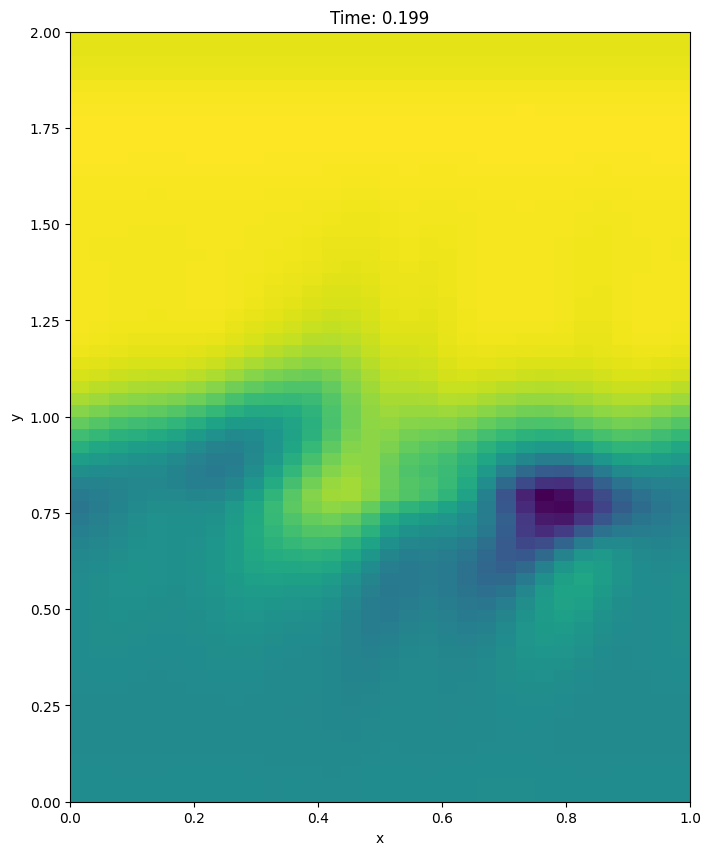

In [ ]:
if __name__ == "__main__":
    print("Starting Rayleigh-Taylor instability simulation...")

    # Run with RK2 (more accurate)
    density_history, time_history = run_simulation(max_time=0.2, use_rk2=True)

    print("Simulation completed!")

    # Create animation
    fig, ax = plt.subplots(figsize=(8, 10))

    def update(frame):
        ax.clear()
        im = ax.imshow(density_history[frame].T, origin='lower',
                       cmap=cm.viridis, extent=[0, Lx, 0, Ly], aspect='auto')
        ax.set_title(f"Time: {time_history[frame]:.3f}")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        return [im]

    ani = FuncAnimation(fig, update, frames=len(density_history),
                        interval=100, blit=True)

    # Save animation
    ani.save('rayleigh_taylor_animation.mp4', writer='ffmpeg', fps=10)

    print("Animation saved to 'rayleigh_taylor_animation.mp4'")
